In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rcParams["figure.autolayout"] = True
# rc('text', usetex=True)

C:\Users\Cevahir Koprulu\anaconda3\envs\racgen\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Cevahir Koprulu\anaconda3\envs\racgen\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Cevahir Koprulu\anaconda3\envs\racgen\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# Point-mass 1D with width 20
bounds = [-7, 7]
bounds_p = [0., .6]
target_m = 3.5
target_s = .7
df = 1
alpha = 0.2
n = 10000
step = 0.05
gamma = 0.99
r_coeff = 0.6
cauchy_bins = 40
gauss_bins = 15
dir = "C:\\Users\\Cevahir Koprulu\\Desktop\\pitfalls_figures"
dpi = 1000

In [3]:
cauchy_rv = stats.t(loc=target_m, scale=target_s, df=df)
cauchy_ppf = np.linspace(stats.t.ppf(0.001, loc=target_m, scale=target_s, df=df), stats.t.ppf(0.999, loc=target_m, scale=target_s, df=df), 10000)
cauchy_samples = stats.t.rvs(loc=target_m, scale=target_s, df=df, size=n)
gauss_rv = stats.norm(loc=target_m, scale=target_s)
gauss_ppf = np.linspace(stats.norm.ppf(0.001, loc=target_m, scale=target_s), stats.norm.ppf(0.999, loc=target_m, scale=target_s), 10000)
gauss_samples = stats.norm.rvs(loc=target_m, scale=target_s, size=n)

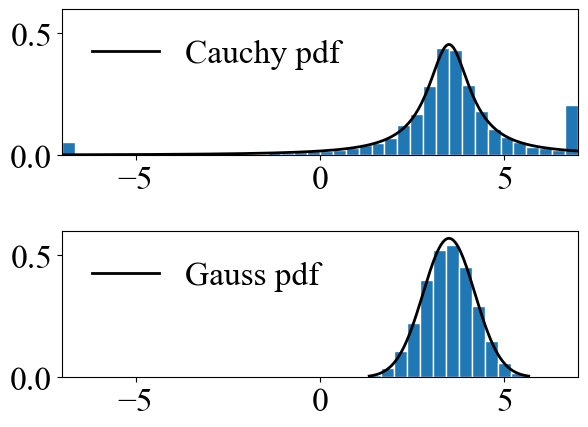

In [4]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(cauchy_ppf, cauchy_rv.pdf(cauchy_ppf), 'k-', lw=2, label='Cauchy pdf')
ax[0].hist(np.clip(cauchy_samples, bounds[0], bounds[1]), density=True, bins=cauchy_bins, edgecolor="white")
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds_p)
ax[0].legend(loc='best', frameon=False)

ax[1].plot(gauss_ppf, gauss_rv.pdf(gauss_ppf), 'k-', lw=2, label='Gauss pdf')
ax[1].hist(np.clip(gauss_samples, bounds[0], bounds[1]), density=True, bins=gauss_bins, edgecolor="white")
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds_p)
ax[1].legend(loc='best', frameon=False)

In [5]:
def get_return(x):
    x = np.array([x, np.zeros(x.shape)])

    init_pos = np.array([0., 3.])
    goal_pos = np.array([0., -3.])
    l1 = np.linalg.norm(x-init_pos)
    n1 = int(l1/step)
    steps1_x = np.linspace(init_pos[0], x[0], n1)
    steps1_y = np.linspace(init_pos[1], x[1], n1)
    steps1 = np.array([steps1_x, steps1_y]).T
    l2 = np.linalg.norm(x-goal_pos)
    n2 = int(l2/step)
    steps2_x = np.linspace(x[0], goal_pos[0], n2)
    steps2_y = np.linspace(x[1], goal_pos[1], n2)
    steps2 = np.array([steps2_x, steps2_y]).T[1:,:]
    steps = np.concatenate((steps1,steps2), axis=0)
    p = np.arange(steps.shape[0], dtype=int)
    gammas = np.ones(steps.shape[0]) * gamma
    disc = np.power(gammas, p)
    dist = np.linalg.norm(steps - goal_pos, axis=1)
    r = np.sum(np.exp(-r_coeff * dist)*disc)
    return r

In [6]:
cauchy_returns = []
for i in range(n):
    cauchy_returns.append(get_return(cauchy_samples[i]))
cauchy_returns = np.array(cauchy_returns)

gauss_returns = []
for i in range(n):
    gauss_returns.append(get_return(gauss_samples[i]))
gauss_returns = np.array(gauss_returns)

In [7]:
m = 1000
contexts = np.linspace(bounds[0], bounds[1], m)
returns = []
for i in range(m):
    returns.append(get_return(contexts[i]))
returns = np.array(returns)

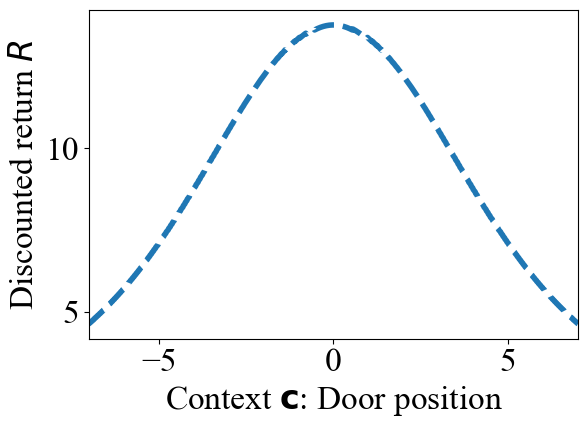

In [8]:
plt.plot(contexts, returns, linestyle="--", marker="", linewidth=4)
plt.xlim(bounds)
plt.xlabel("Context $\mathbf{c}$: Door position")
plt.ylabel(r"Discounted return $R$")
plt.savefig(f"{dir}\\return_vs_context.pdf", dpi=dpi, bbox_inches='tight')

In [9]:
cauchy_cvar = np.mean(cauchy_returns[cauchy_returns <= np.quantile(cauchy_returns, q=alpha)])
cauchy_med = np.median(cauchy_returns)
cauchy_mean = np.mean(cauchy_returns)
gauss_q = np.quantile(gauss_returns, q=alpha)
gauss_cvar = np.mean(gauss_returns[gauss_returns <= gauss_q])
gauss_med = np.median(gauss_returns)
gauss_mean = np.mean(gauss_returns)

In [10]:
cauchy_cvar, cauchy_med, cauchy_mean, gauss_cvar, gauss_med, gauss_mean

(4.89896738514828,
 9.520363069419163,
 9.12362380785174,
 7.930736042468024,
 9.651903554492128,
 9.66756268495995)

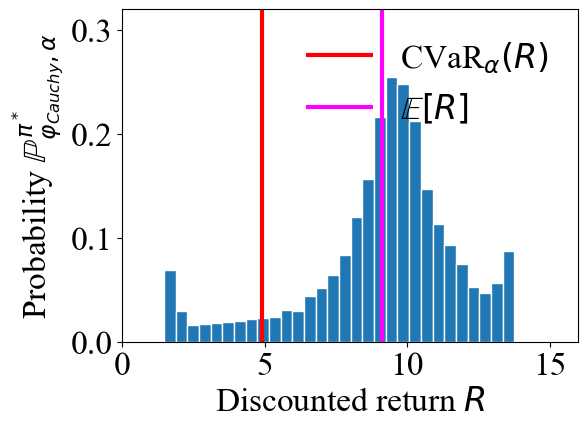

In [11]:
return_max = 16.
bound_p2 = .32
plt.hist(cauchy_returns, density=True, bins=30, edgecolor='white')
plt.xlim([0., return_max])
plt.ylim([0., bound_p2])
plt.vlines(cauchy_cvar, 0., bound_p2, colors="red", label=r"CVaR$_{\alpha}(R)$", linewidth=3)
# plt.vlines(cauchy_med, 0., bound_p2, colors="green", label="med")
plt.vlines(cauchy_mean, 0., bound_p2, colors="magenta", label=r"$\mathbb{E}[R]$", linewidth=3)
plt.ylabel(r"Probability $\mathbb{P}_{\varphi_{Cauchy},\alpha}^{\pi^*}$")
plt.xlabel("Discounted return $R$")
plt.legend(loc='upper right', frameon=False)
plt.savefig(f"{dir}\\return_dist_cauchy.pdf", dpi=dpi, bbox_inches='tight')

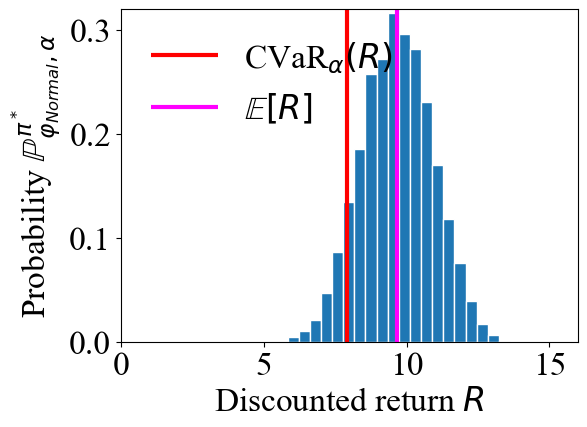

In [12]:
plt.hist(gauss_returns, density=True, bins=20, edgecolor='white')
plt.xlim([0., return_max])
plt.ylim([0., bound_p2])
plt.vlines(gauss_cvar, 0., bound_p2, colors="red", label=r"CVaR$_{\alpha}(R)$", linewidth=3)
# plt.vlines(gauss_med, 0., bound_p2, colors="green", label="med")
plt.vlines(gauss_mean, 0., bound_p2, colors="magenta", label=r"$\mathbb{E}[R]$", linewidth=3)
plt.ylabel(r"Probability $\mathbb{P}_{\varphi_{Normal},\alpha}^{\pi^*}$")
plt.xlabel("Discounted return $R$")
plt.legend(loc='upper left', frameon=False)
plt.savefig(f"{dir}\\return_dist_gauss.pdf", dpi=dpi, bbox_inches='tight')

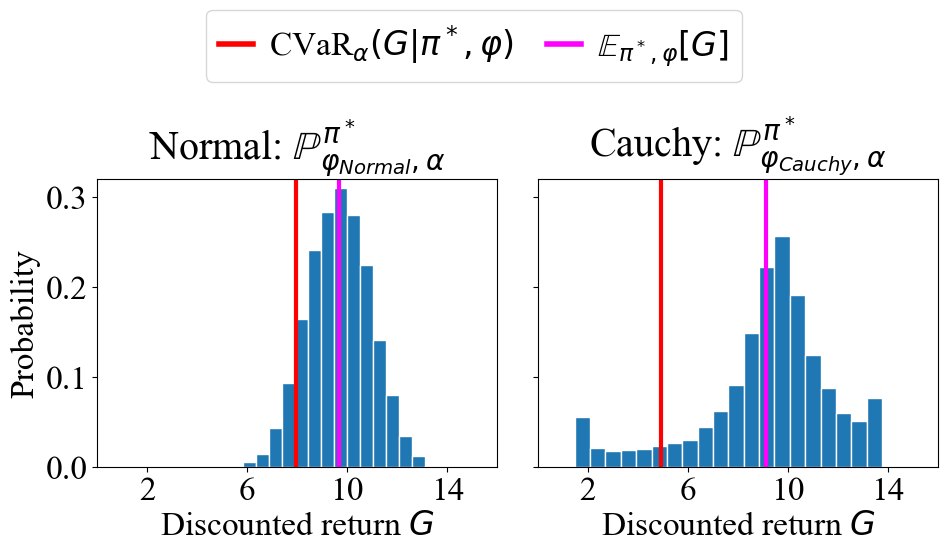

In [33]:
fig, axes = plt.subplots(1,2,figsize=(10,5),constrained_layout=True)

axes[0].hist(gauss_returns, density=True, bins=15, edgecolor='white')
axes[0].set_xlim([0., return_max])
axes[0].set_ylim([0., bound_p2])
axes[0].vlines(gauss_cvar, 0., bound_p2, colors="red", linewidth=3)
axes[0].vlines(gauss_mean, 0., bound_p2, colors="magenta", linewidth=3)
axes[0].set_ylabel(r"Probability")
axes[0].set_xlabel("Discounted return $G$")
axes[0].set_title(r"Normal: $\mathbb{P}_{\varphi_{Normal},\alpha}^{\pi^*}$")
axes[0].set_xticks([2,6,10,14])

axes[1].hist(cauchy_returns, density=True, bins=20, edgecolor='white')
axes[1].set_xlim([0., return_max])
axes[1].set_ylim([0., bound_p2])
axes[1].vlines(cauchy_cvar, 0., bound_p2, colors="red", linewidth=3)
axes[1].vlines(cauchy_mean, 0., bound_p2, colors="magenta", linewidth=3)
axes[1].set_xlabel("Discounted return $G$")
axes[1].set_yticklabels([])
axes[1].set_xticks([2,6,10,14])
axes[1].set_title(r"Cauchy: $\mathbb{P}_{\varphi_{Cauchy},\alpha}^{\pi^*}$")

labels = [r"CVaR$_{\alpha}(G|\pi^*,\varphi)$", r"$\mathbb{E}_{\pi^*,\varphi}[G]$"]
colors = ["red", "magenta"]
lines = []
for i in range(2):
    lines.append(Line2D([0], [0], color=colors[i], linestyle="-", linewidth=4.0))
lgd = fig.legend(lines, labels, ncol=2, loc="upper center", bbox_to_anchor=(.5, 1.17),
                 handlelength=1.0, labelspacing=0., handletextpad=0.5, columnspacing=1.0)

plt.savefig(f"{dir}\\return_dist.pdf", dpi=dpi, bbox_inches='tight', bbox_extra_artists=(lgd,))

In [14]:
cauchy_risky = cauchy_samples[cauchy_returns<=cauchy_cvar]
cauchy_nonrisky = cauchy_samples[cauchy_returns>cauchy_cvar]
cauchy_risky_min = np.max(cauchy_risky[cauchy_risky<target_m])
cauchy_risky_max = np.min(cauchy_risky[cauchy_risky>target_m])

gauss_risky = gauss_samples[gauss_returns<=gauss_cvar]
gauss_nonrisky = gauss_samples[gauss_returns>gauss_cvar]
gauss_risky_min = np.max(gauss_risky[gauss_risky<target_m]) if gauss_risky[gauss_risky<target_m].shape[0] > 0 else bounds[0]
gauss_risky_max = np.min(gauss_risky[gauss_risky>target_m])

In [15]:
cauchy_risky_min,cauchy_risky_max,gauss_risky_min,gauss_risky_max

(-6.8282967740402185, 6.7411261450816005, -7, 4.484611179729232)

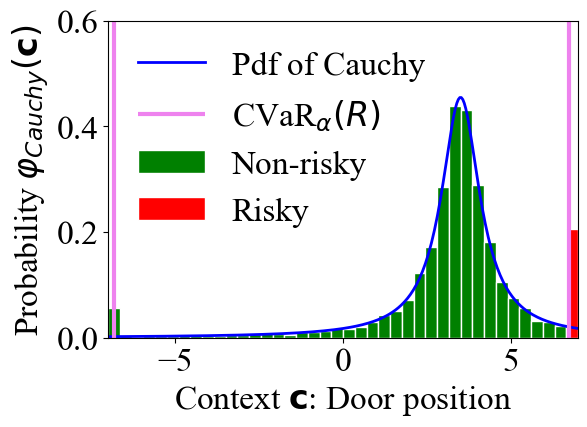

In [16]:
plt.plot(cauchy_ppf, cauchy_rv.pdf(cauchy_ppf), 'blue', lw=2, label='Pdf of Cauchy')
plt.vlines(cauchy_risky_min, 0., bounds_p[1], colors="violet", linewidth=3, label=r"CVaR$_{\alpha}(R)$")
plt.vlines(cauchy_risky_max, 0., bounds_p[1], colors="violet", linewidth=3)
N, bins, patches = plt.hist(np.clip(cauchy_samples, bounds[0], bounds[1]), density=True, bins=cauchy_bins)
risky_label = True
nonrisky_label = True
for i in range(1, bins.shape[0]):
    if bins[i] <= cauchy_risky_min or bins[i] >= cauchy_risky_max:
        patches[i-1].set_color("red")
        patches[i-1].set_edgecolor("white")
        if risky_label:
            patches[i-1].set_label("Risky")
            risky_label = False
    else:
        patches[i-1].set_color("green")
        patches[i-1].set_edgecolor("white")
        if nonrisky_label:
            patches[i-1].set_label("Non-risky")
            nonrisky_label = False
plt.xlim(bounds)
plt.ylim(bounds_p)
plt.ylabel(r"Probability $\varphi_{Cauchy}(\mathbf{c})$")
plt.xlabel("Context $\mathbf{c}$: Door position")
plt.legend(loc='upper left', frameon=False)
plt.savefig(f"{dir}\\target_cauchy_cvar.pdf", dpi=dpi, bbox_inches='tight')

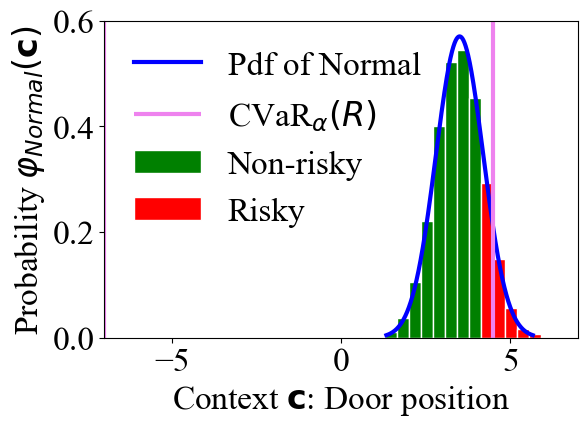

In [17]:
plt.plot(gauss_ppf, gauss_rv.pdf(gauss_ppf), 'blue', lw=3, label='Pdf of Normal')
plt.vlines(gauss_risky_min, 0., bounds_p[1], colors="violet", linewidth=3, label=r"CVaR$_{\alpha}(R)$")
plt.vlines(gauss_risky_max, 0., bounds_p[1], colors="violet", linewidth=3)
N, bins, patches = plt.hist(np.clip(gauss_samples, bounds[0], bounds[1]), density=True, bins=gauss_bins)
risky_label = True
nonrisky_label = True
for i in range(1, bins.shape[0]):
    if bins[i] <= gauss_risky_min or bins[i] >= gauss_risky_max:
        patches[i-1].set_color("red")
        patches[i-1].set_edgecolor("white")
        if risky_label:
            patches[i-1].set_label("Risky")
            risky_label = False
    else:
        patches[i-1].set_color("green")
        patches[i-1].set_edgecolor("white")
        if nonrisky_label:
            patches[i-1].set_label("Non-risky")
            nonrisky_label = False
plt.xlim(bounds)
plt.ylim(bounds_p)
plt.ylabel(r"Probability $\varphi_{Normal}(\mathbf{c})$")
plt.xlabel("Context $\mathbf{c}$: Door position")
plt.legend(loc='upper left', frameon=False)
plt.savefig(f"{dir}\\target_gauss_cvar.pdf", dpi=dpi, bbox_inches='tight')

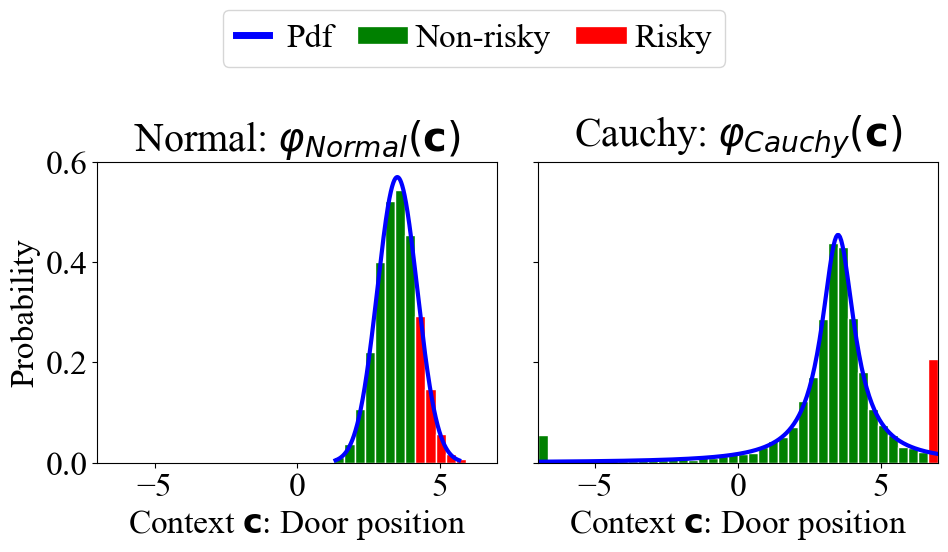

In [31]:
fig, axes = plt.subplots(1,2,figsize=(10,5),constrained_layout=True)

axes[0].plot(gauss_ppf, gauss_rv.pdf(gauss_ppf), 'blue', lw=3)
N, bins, patches = axes[0].hist(np.clip(gauss_samples, bounds[0], bounds[1]), density=True, bins=gauss_bins)
risky_label = True
nonrisky_label = True
for i in range(1, bins.shape[0]):
    if bins[i] <= gauss_risky_min or bins[i] >= gauss_risky_max:
        patches[i-1].set_color("red")
        patches[i-1].set_edgecolor("white")
        if risky_label:
            patches[i-1].set_label("Risky")
            risky_label = False
    else:
        patches[i-1].set_color("green")
        patches[i-1].set_edgecolor("white")
        if nonrisky_label:
            patches[i-1].set_label("Non-risky")
            nonrisky_label = False
axes[0].set_xlim(bounds)
axes[0].set_ylim(bounds_p)
axes[0].set_ylabel(r"Probability")
axes[0].set_xlabel("Context $\mathbf{c}$: Door position")
axes[0].set_title(r"Normal: $\varphi_{Normal}(\mathbf{c})$")

axes[1].plot(cauchy_ppf, cauchy_rv.pdf(cauchy_ppf), 'blue', lw=3)
N, bins, patches = axes[1].hist(np.clip(cauchy_samples, bounds[0], bounds[1]), density=True, bins=cauchy_bins)
risky_label = True
nonrisky_label = True
for i in range(1, bins.shape[0]):
    if bins[i] <= cauchy_risky_min or bins[i] >= cauchy_risky_max:
        patches[i-1].set_color("red")
        patches[i-1].set_edgecolor("white")
        if risky_label:
            patches[i-1].set_label("Risky")
            risky_label = False
    else:
        patches[i-1].set_color("green")
        patches[i-1].set_edgecolor("white")
        if nonrisky_label:
            patches[i-1].set_label("Non-risky")
            nonrisky_label = False
axes[1].set_xlim(bounds)
axes[1].set_ylim(bounds_p)
axes[1].set_xlabel("Context $\mathbf{c}$: Door position")
axes[1].set_yticklabels([])
axes[1].set_title(r"Cauchy: $\varphi_{Cauchy}(\mathbf{c})$")

labels = ["Pdf","Non-risky", "Risky"]
colors = ["blue","green", "red"]
lw = [5, 12, 12]
lines = []
for i in range(3):
    lines.append(Line2D([0], [0], color=colors[i], linestyle="-", linewidth=lw[i]))
lgd = fig.legend(lines, labels, ncol=3, loc="upper center", bbox_to_anchor=(.5, 1.17),
                 handlelength=1.0, labelspacing=0., handletextpad=0.5, columnspacing=1.0)

plt.savefig(f"{dir}\\target_cvar.pdf", dpi=dpi, bbox_inches='tight', bbox_extra_artists=(lgd,))

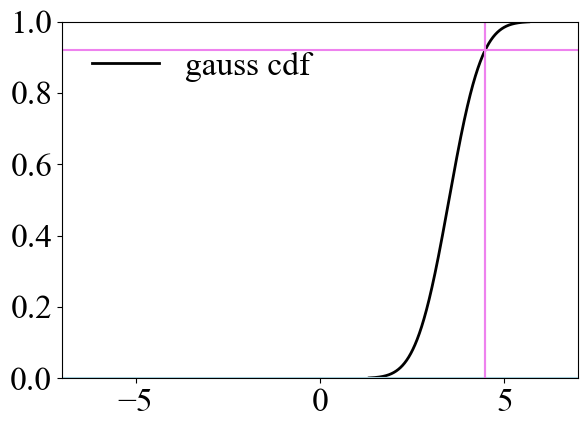

In [19]:
plt.plot(gauss_ppf, gauss_rv.cdf(gauss_ppf), 'k-', lw=2, label='gauss cdf')
plt.hlines(gauss_rv.cdf(gauss_risky_min), bounds[0], bounds[1], colors="lightblue")
plt.hlines(gauss_rv.cdf(gauss_risky_max), bounds[0], bounds[1], colors="violet")
plt.vlines(gauss_risky_min, 0., 1., colors="lightblue")
plt.vlines(gauss_risky_max, 0., 1., colors="violet")
plt.vlines(gauss_risky_max, 0., 1., colors="violet")
plt.xlim(bounds)
plt.ylim([0., 1.])
plt.legend(loc='best', frameon=False)

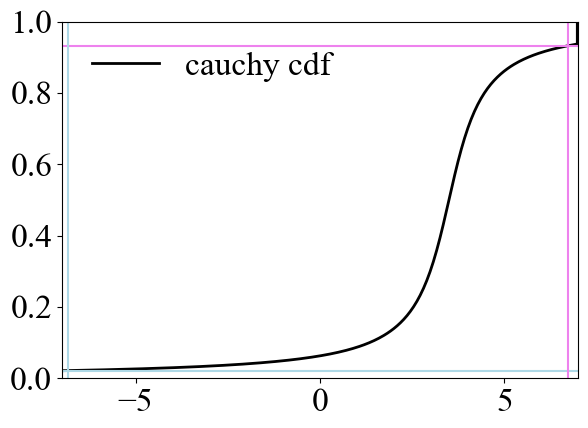

In [20]:
plt.plot(cauchy_ppf, cauchy_rv.cdf(cauchy_ppf), 'k-', lw=2, label='cauchy cdf')
plt.vlines(bounds[1], cauchy_rv.cdf(bounds[1]), 1.0, 'black', lw=3)
plt.hlines(cauchy_rv.cdf(cauchy_risky_min), bounds[0], bounds[1], colors="lightblue")
plt.hlines(cauchy_rv.cdf(cauchy_risky_max), bounds[0], bounds[1], colors="violet")
plt.vlines(cauchy_risky_min, 0., 1., colors="lightblue")
plt.vlines(cauchy_risky_max, 0., 1., colors="violet")
plt.xlim(bounds)
plt.ylim([0., 1.])
plt.legend(loc='best', frameon=False)

In [21]:
cauchy_rv.cdf(cauchy_risky_max)-cauchy_rv.cdf(cauchy_risky_min)

0.9107526809400447

In [22]:
gauss_rv.cdf(gauss_risky_max)-gauss_rv.cdf(gauss_risky_min)

0.9202251142063484

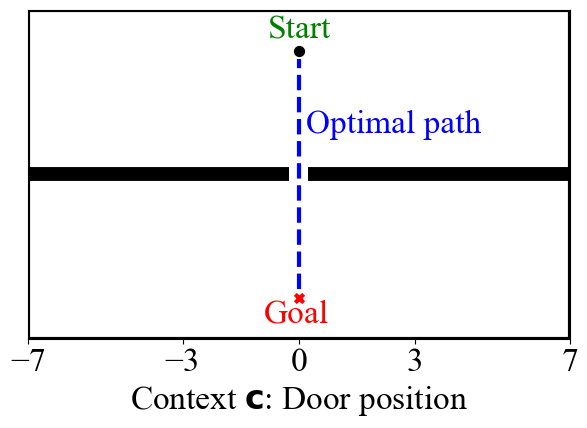

In [56]:
plt.hlines(-4, bounds[0], bounds[1], color="black", linewidth=3)
plt.hlines(4, bounds[0], bounds[1], color="black", linewidth=3)
plt.vlines(bounds[0], -4, 4, color="black", linewidth=3)
plt.vlines(bounds[1], -4, 4, color="black", linewidth=3)
plt.hlines(0, bounds[0], -0.25, color="black", linewidth=10)
plt.hlines(0, 0.25, bounds[1], color="black", linewidth=10)
plt.scatter(0, -3, marker="x", color="red", linewidths=3)
plt.annotate("Goal", (-.9, -3.6), color="red")
# plt.scatter(-0.05, 3, marker=r'$\downarrow$', color="green", linewidths=2)
plt.scatter(0., 3, s=50, color="black")
plt.annotate("Start", (-0.8, 3.3), color="green")
plt.vlines(0., -2.8, 2.8, color="blue", linestyles="--", linewidth=3)
plt.annotate("Optimal path", (0.2, 1.0), color="blue")
plt.ylim([-4, 4])
# plt.ylabel("Position along y-axis")
plt.xlabel(r"Context $\mathbf{c}$: Door position")
# plt.axis("off")
plt.yticks([])
plt.xticks([-7,-3,0,3,7])
plt.xlim(bounds)
plt.savefig(f"{dir}\\point_mass_1d.pdf", dpi=dpi, bbox_inches='tight')